# Prepare MR-NIRP_Indoor dataset for easier loading

In [1]:
import os
import time
import glob
import numpy as np
import cv2
import scipy.io as sio
import scipy.signal as sig
import matplotlib.pyplot as plt
from tqdm import tqdm
import face_recognition  # FUTURE: replace with other face or landmark detector to stabilize the face_locations
from IPython.display import display, Image

In [2]:
dataset_root_path: str = '/mnt/Data/MR-NIRP_Indoor/'
img_resize_h: int = 128
img_resize_w: int = 128
img_max_value: int = 2 ** 16 - 1  # 16-bit
video_fps: float = 30.
ppg_fps: float = 60.

The original subfolders name under Subject2_still_940 is wrong,
"cam_flea3_1" should be "RGB" and "RGB" should be "NIR", which have been corrected manually.

In [3]:
display_handle=display(None, display_id=True)  # Visualization

for subject_folder in tqdm(glob.glob(os.path.join(dataset_root_path, '*'))):
    if not os.path.isdir(subject_folder):
        continue

    subject_name = os.path.basename(subject_folder)
    print('Processing subject: {}'.format(subject_name))

    nir_path_list = sorted(glob.glob(os.path.join(subject_folder, "NIR", "*.pgm")))

    nir_imgs = []
    face_locations = []
    for nir_path in nir_path_list:
        nir_img = cv2.imread(nir_path, cv2.IMREAD_UNCHANGED)
        nir_img = cv2.resize(nir_img, (img_resize_w, img_resize_h), interpolation=cv2.INTER_AREA)
        nir_img = nir_img.astype(np.float32) / img_max_value  # Normalize to [0, 1]
        nir_imgs.append(nir_img)

        nir_img_face_locations = face_recognition.face_locations((nir_img / nir_img.max() * 255).astype(np.uint8), model="cnn")
        if len(nir_img_face_locations) != 1:
            raise ValueError(f"Detect {len(nir_img_face_locations)} (!= 1) faces in {nir_path}.")
        top, right, bottom, left = nir_img_face_locations[0]
        face_location = np.array([left, top, right, bottom])
        face_locations.append(face_location)

        # Visualization
        nir_img = (nir_img[max(0,top):min(nir_img.shape[1],bottom), max(0,left):min(nir_img.shape[0],right)] / nir_img.max() * 255).astype(np.uint8)
        if nir_img.size == 0 or nir_img.shape[0] < 10 or nir_img.shape[1] < 10 or np.all(nir_img < 10):
            raise ValueError(f"Face detection error in {nir_path}.\n\tReason: {nir_img.size=}, {nir_img.shape=}, {face_location=}")
        _, frame = cv2.imencode('.jpeg', nir_img)
        display_handle.update(Image(data=frame.tobytes()))

    nir_imgs = np.array(nir_imgs)
    print(f"{nir_imgs.shape=}, {nir_imgs.dtype=}, {nir_imgs.min()=}, {nir_imgs.max()=}")

    face_locations = np.stack(face_locations, axis=0)

    ppg_mat = sio.loadmat(os.path.join(subject_folder, "PulseOX", "pulseOx.mat"))
    ppg_signal_corrupted = ppg_mat["pulseOxRecord"].squeeze()
    ppg_time_corrupted = ppg_mat["pulseOxTime"][0]
    ppg_labels, ppg_time = [], []
    for idx, (value, time) in enumerate(zip(ppg_signal_corrupted, ppg_time_corrupted)):
        num_values = len(value[0]) if isinstance(value, np.ndarray) else 1
        if num_values > 1:  # Multiple values at a time step due to queued delayed ppg signal
            for sub_idx, sub_value in enumerate(value[0]):
                ppg_time.append(ppg_time_corrupted[idx-1] + ((sub_idx+1) / num_values) * (time - ppg_time_corrupted[idx-1]))
                ppg_labels.append(sub_value)
        else:
            ppg_time.append(time)
            ppg_labels.append(value.item())
    ppg_labels = np.array(ppg_labels)
    ppg_time = np.array(ppg_time)

    npz_path = os.path.join(dataset_root_path, f"{subject_name}.npz")
    np.savez(npz_path, nir_imgs=nir_imgs, ppg_labels=ppg_labels, ppg_time=ppg_time, face_locations=face_locations)

display_handle.update(None)  # Visualization

None

  0%|          | 0/16 [00:00<?, ?it/s]

Processing subject: Subject6_still_940
nir_imgs.shape=(5812, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.070160985, nir_imgs.max()=0.6118105


  6%|▋         | 1/16 [00:41<10:28, 41.90s/it]

Processing subject: Subject2_still_940
nir_imgs.shape=(6310, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.048950944, nir_imgs.max()=0.64853895


 12%|█▎        | 2/16 [01:23<09:46, 41.89s/it]

Processing subject: Subject4_still_940
nir_imgs.shape=(5411, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.04789807, nir_imgs.max()=0.78959334


 19%|█▉        | 3/16 [02:01<08:41, 40.14s/it]

Processing subject: Subject4_motion_940


 25%|██▌       | 4/16 [02:13<05:48, 29.04s/it]

nir_imgs.shape=(1847, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.047486078, nir_imgs.max()=0.9010758
Processing subject: Subject3_still_940
nir_imgs.shape=(7230, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.046707865, nir_imgs.max()=0.75344473


 31%|███▏      | 5/16 [03:02<06:35, 35.95s/it]

Processing subject: Subject8_motion_940


 38%|███▊      | 6/16 [03:13<04:36, 27.63s/it]

nir_imgs.shape=(1826, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.050598916, nir_imgs.max()=0.96247804
Processing subject: Subject3_motion_940


 44%|████▍     | 7/16 [03:24<03:20, 22.32s/it]

nir_imgs.shape=(1817, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.044235904, nir_imgs.max()=0.62043184
Processing subject: Subject6_motion_940


 50%|█████     | 8/16 [03:36<02:30, 18.81s/it]

nir_imgs.shape=(1815, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.06802472, nir_imgs.max()=0.69892424
Processing subject: Subject8_still_940
nir_imgs.shape=(5422, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.052689403, nir_imgs.max()=0.89504844


 56%|█████▋    | 9/16 [04:11<02:47, 23.98s/it]

Processing subject: Subject2_motion_940


 62%|██████▎   | 10/16 [04:22<01:59, 19.93s/it]

nir_imgs.shape=(1821, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.049546044, nir_imgs.max()=0.6962844
Processing subject: Subject1_still_940
nir_imgs.shape=(5386, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.038773175, nir_imgs.max()=0.6774395


 69%|██████▉   | 11/16 [04:55<02:00, 24.10s/it]

Processing subject: Subject7_still_940
nir_imgs.shape=(5413, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.067338064, nir_imgs.max()=0.84757763


 75%|███████▌  | 12/16 [05:32<01:51, 27.83s/it]

Processing subject: Subject5_still_940
nir_imgs.shape=(5415, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.08453498, nir_imgs.max()=0.6352026


 81%|████████▏ | 13/16 [06:09<01:31, 30.58s/it]

Processing subject: Subject7_motion_940


 88%|████████▊ | 14/16 [06:21<00:49, 24.96s/it]

nir_imgs.shape=(1824, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.06582742, nir_imgs.max()=0.8135042
Processing subject: Subject1_motion_940


100%|██████████| 16/16 [06:33<00:00, 24.56s/it]

nir_imgs.shape=(1967, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.03994812, nir_imgs.max()=0.7066453


Each *.npz:
- nir_img_array.shape = (t@30fps, h=img_resize_h, w=img_resize_w)
- ppg_signal = (t'@60fps,)
- ppg_signal = (t'@60fps,)

Loading /mnt/Data/MR-NIRP_Indoor/Subject6_still_940.npz
nir_imgs.shape=(5812, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.070160985, nir_imgs.max()=0.6118105
ppg_labels.shape=(10773,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=9, ppg_labels.max()=102
ppg_time.shape=(10773,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1518987793.190641, ppg_time.max()=1518987973.739428
face_locations.shape=(5812, 4), face_locations.dtype=dtype('int64'), face_locations.min()=20, face_locations.max()=122


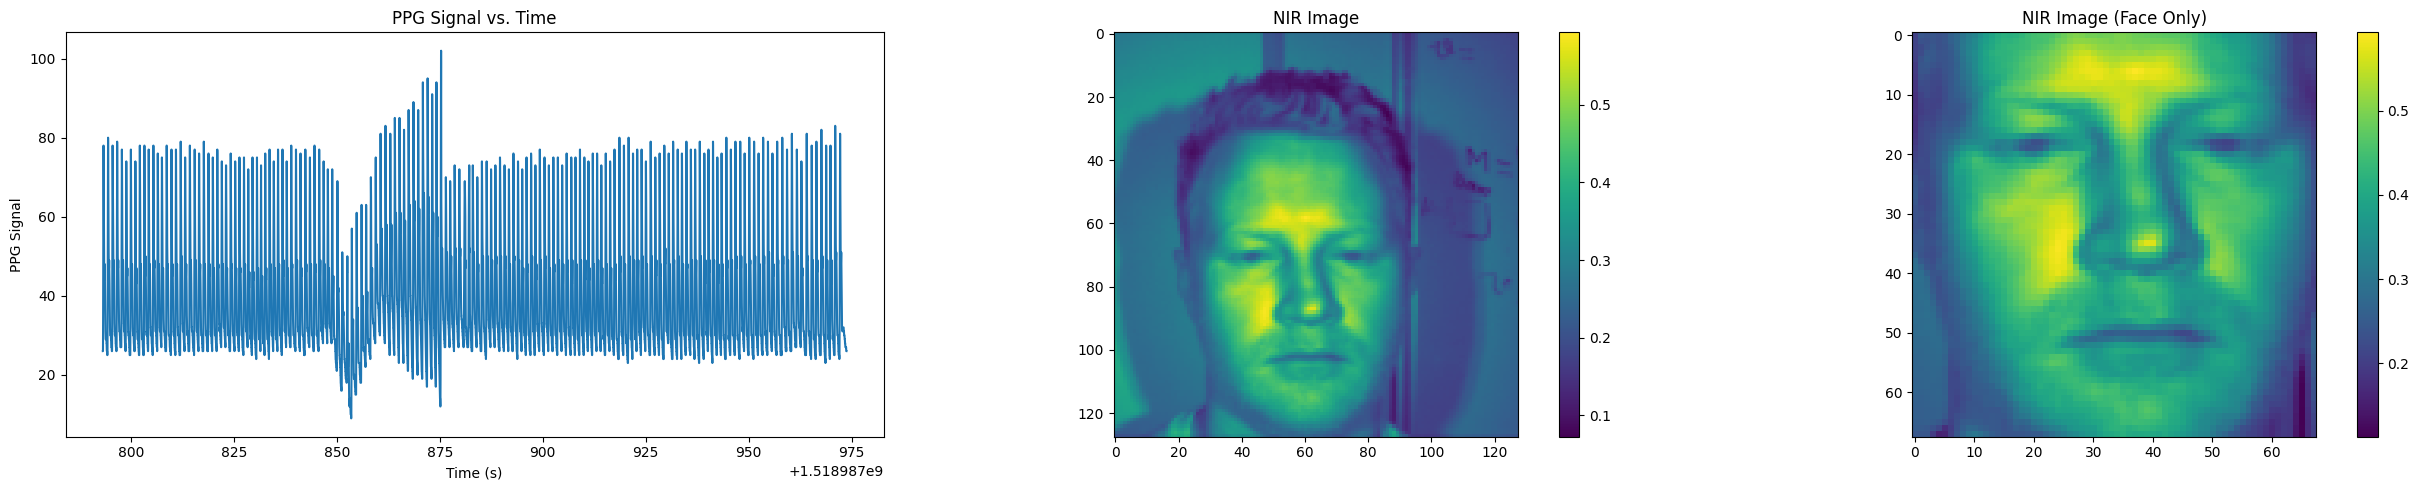

Loading /mnt/Data/MR-NIRP_Indoor/Subject2_still_940.npz
nir_imgs.shape=(6310, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.048950944, nir_imgs.max()=0.64853895
ppg_labels.shape=(12599,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=78
ppg_time.shape=(12599,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519084234.486923, ppg_time.max()=1519084444.883562
face_locations.shape=(6310, 4), face_locations.dtype=dtype('int64'), face_locations.min()=16, face_locations.max()=107


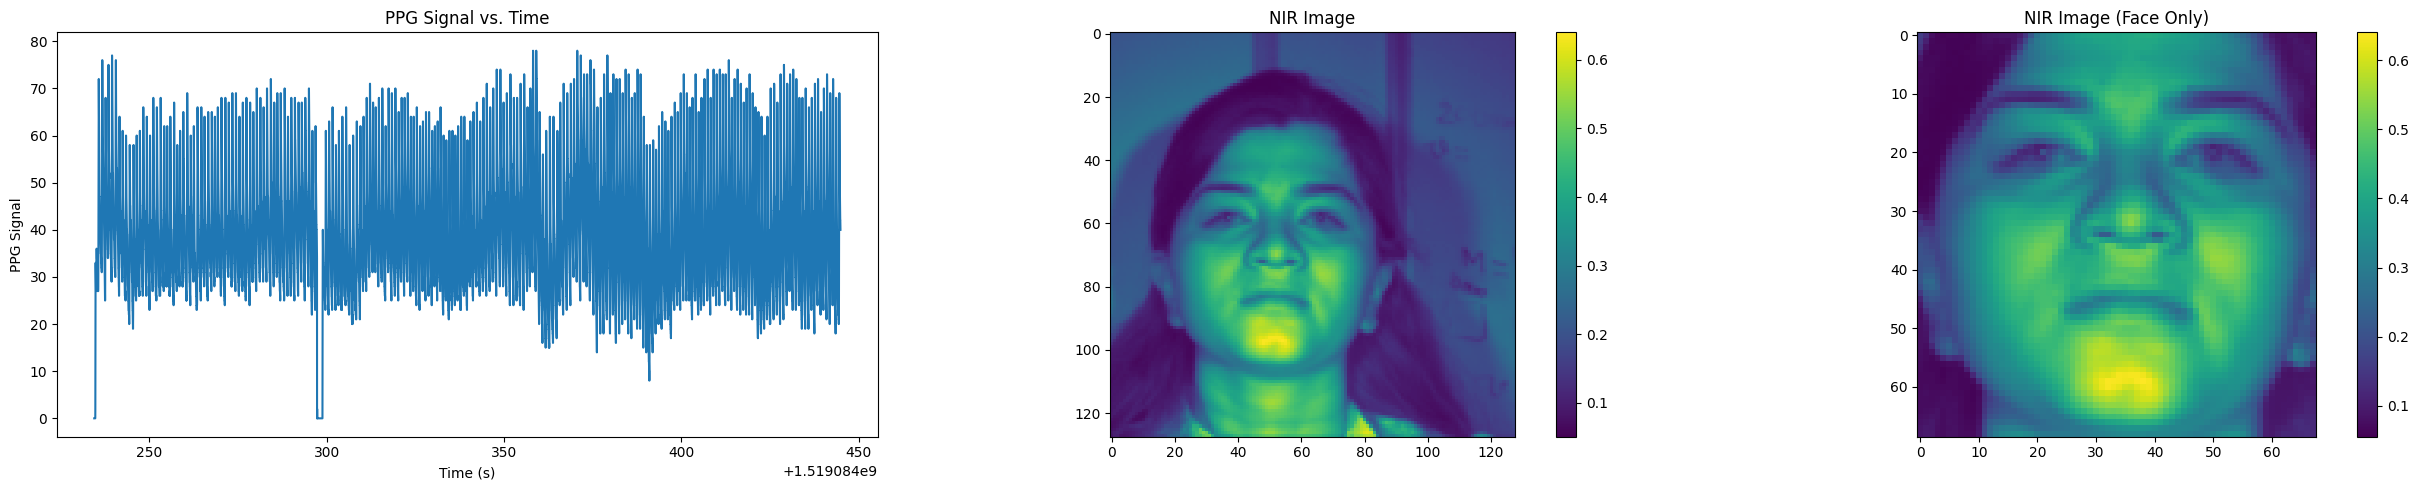

Loading /mnt/Data/MR-NIRP_Indoor/Subject5_still_940.npz
nir_imgs.shape=(5415, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.08453498, nir_imgs.max()=0.6352026
ppg_labels.shape=(10813,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=20, ppg_labels.max()=109
ppg_time.shape=(10813,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519071639.565325, ppg_time.max()=1519071820.093296
face_locations.shape=(5415, 4), face_locations.dtype=dtype('int64'), face_locations.min()=11, face_locations.max()=114


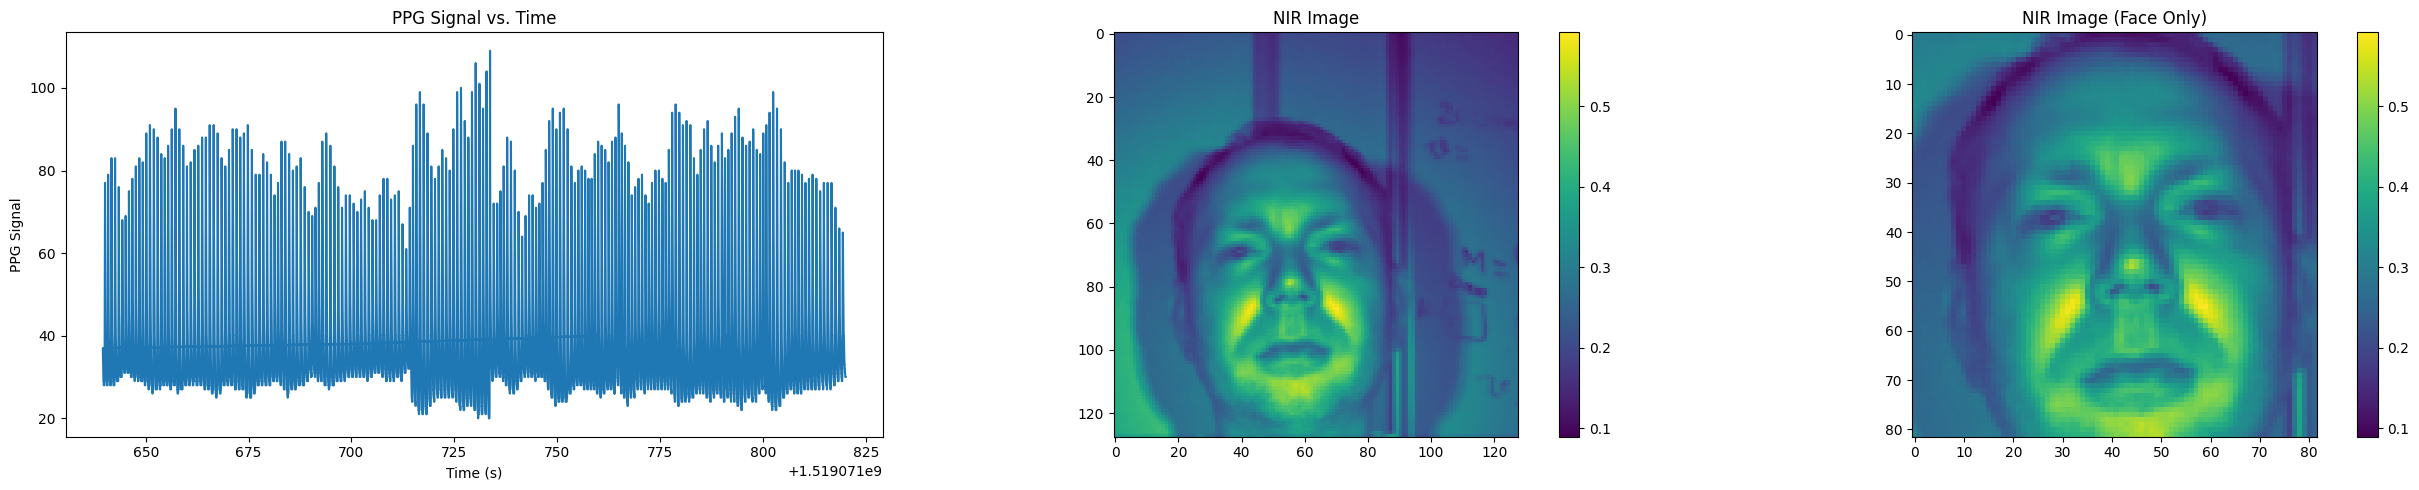

Loading /mnt/Data/MR-NIRP_Indoor/Subject8_still_940.npz
nir_imgs.shape=(5422, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.052689403, nir_imgs.max()=0.89504844
ppg_labels.shape=(10796,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=103
ppg_time.shape=(10796,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519074359.050833, ppg_time.max()=1519074539.336365
face_locations.shape=(5422, 4), face_locations.dtype=dtype('int64'), face_locations.min()=3, face_locations.max()=107


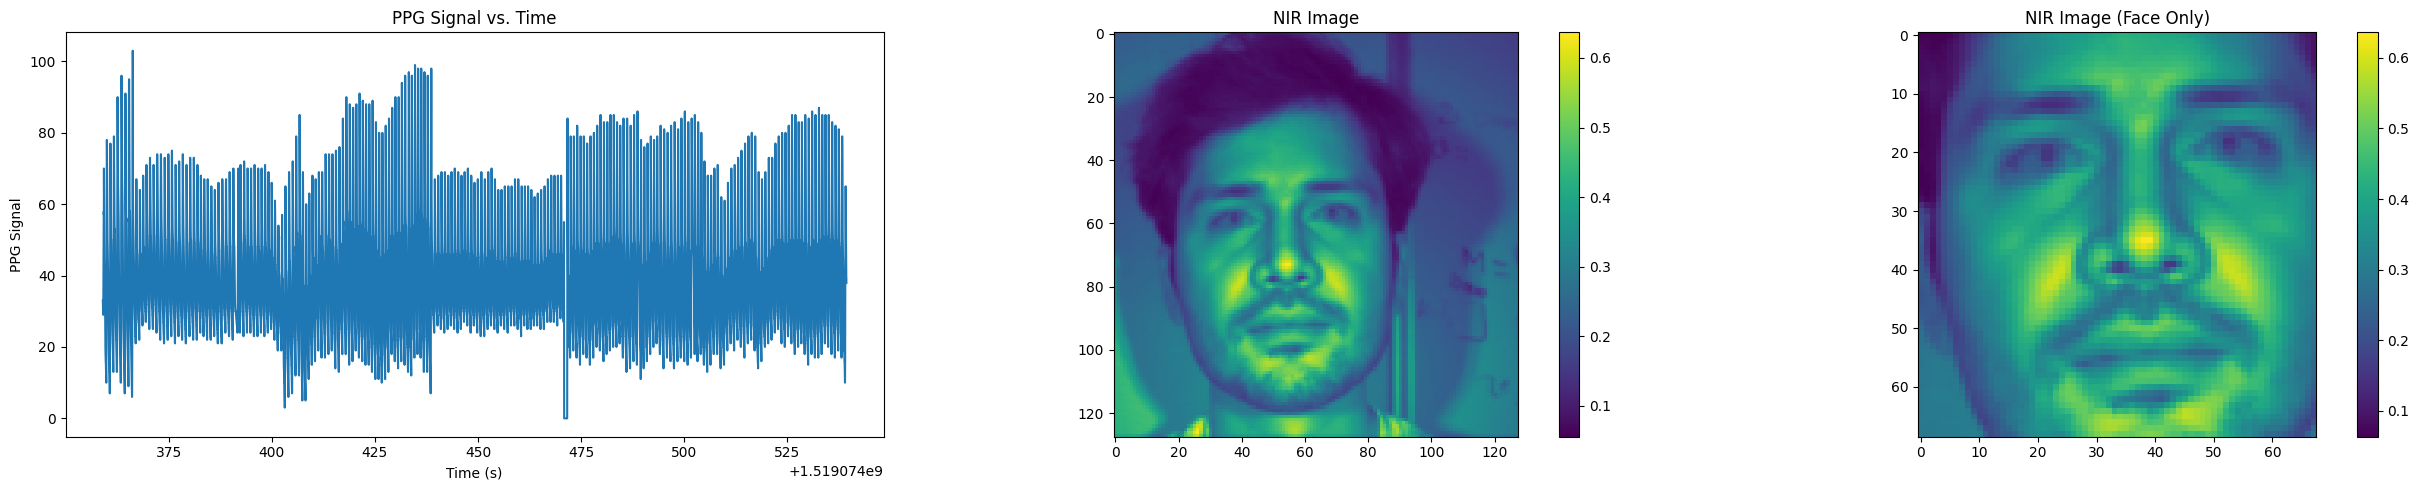

Loading /mnt/Data/MR-NIRP_Indoor/Subject8_motion_940.npz
nir_imgs.shape=(1826, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.050598916, nir_imgs.max()=0.96247804
ppg_labels.shape=(3645,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=92
ppg_time.shape=(3645,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519074856.770411, ppg_time.max()=1519074917.628251
face_locations.shape=(1826, 4), face_locations.dtype=dtype('int64'), face_locations.min()=11, face_locations.max()=114


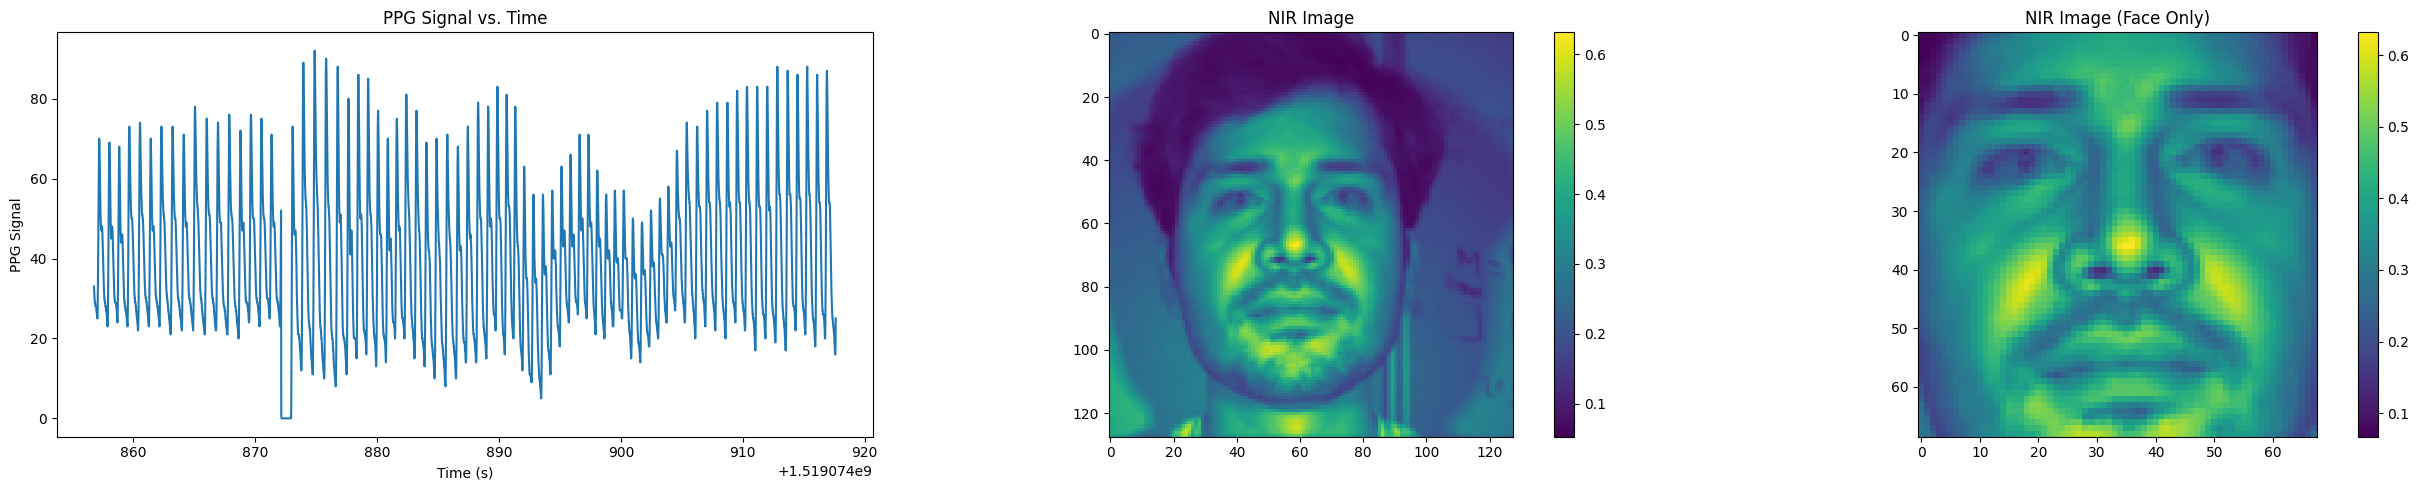

Loading /mnt/Data/MR-NIRP_Indoor/Subject6_motion_940.npz
nir_imgs.shape=(1815, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.06802472, nir_imgs.max()=0.69892424
ppg_labels.shape=(3623,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=22, ppg_labels.max()=88
ppg_time.shape=(3623,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1518988273.248452, ppg_time.max()=1518988333.73562
face_locations.shape=(1815, 4), face_locations.dtype=dtype('int64'), face_locations.min()=28, face_locations.max()=122


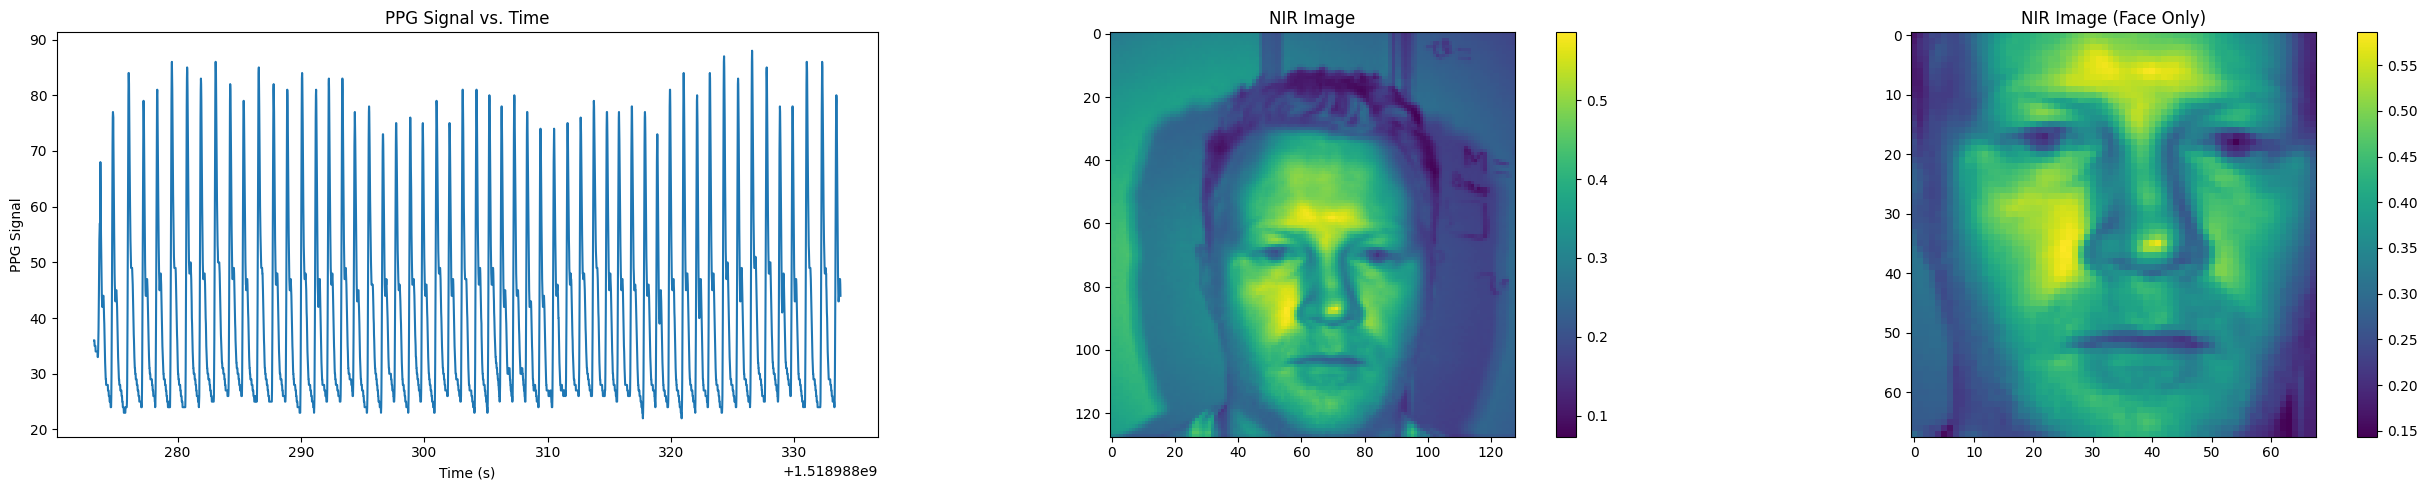

Loading /mnt/Data/MR-NIRP_Indoor/Subject7_motion_940.npz
nir_imgs.shape=(1824, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.06582742, nir_imgs.max()=0.8135042
ppg_labels.shape=(3640,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=108
ppg_time.shape=(3640,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519077623.385428, ppg_time.max()=1519077684.160324
face_locations.shape=(1824, 4), face_locations.dtype=dtype('int64'), face_locations.min()=10, face_locations.max()=120


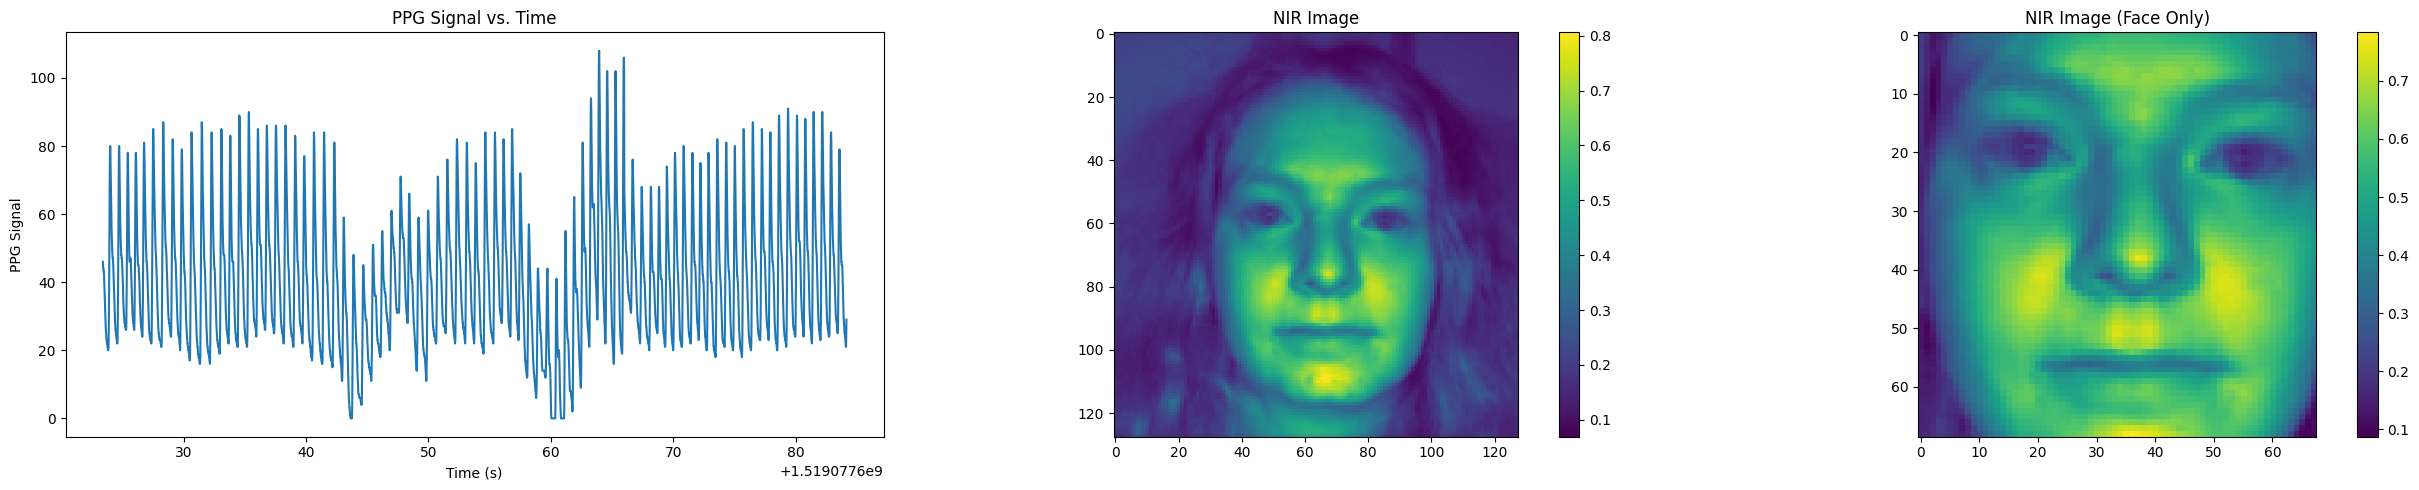

Loading /mnt/Data/MR-NIRP_Indoor/Subject7_still_940.npz
nir_imgs.shape=(5413, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.067338064, nir_imgs.max()=0.84757763
ppg_labels.shape=(10809,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=94
ppg_time.shape=(10809,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519077361.366078, ppg_time.max()=1519077541.868629
face_locations.shape=(5413, 4), face_locations.dtype=dtype('int64'), face_locations.min()=10, face_locations.max()=120


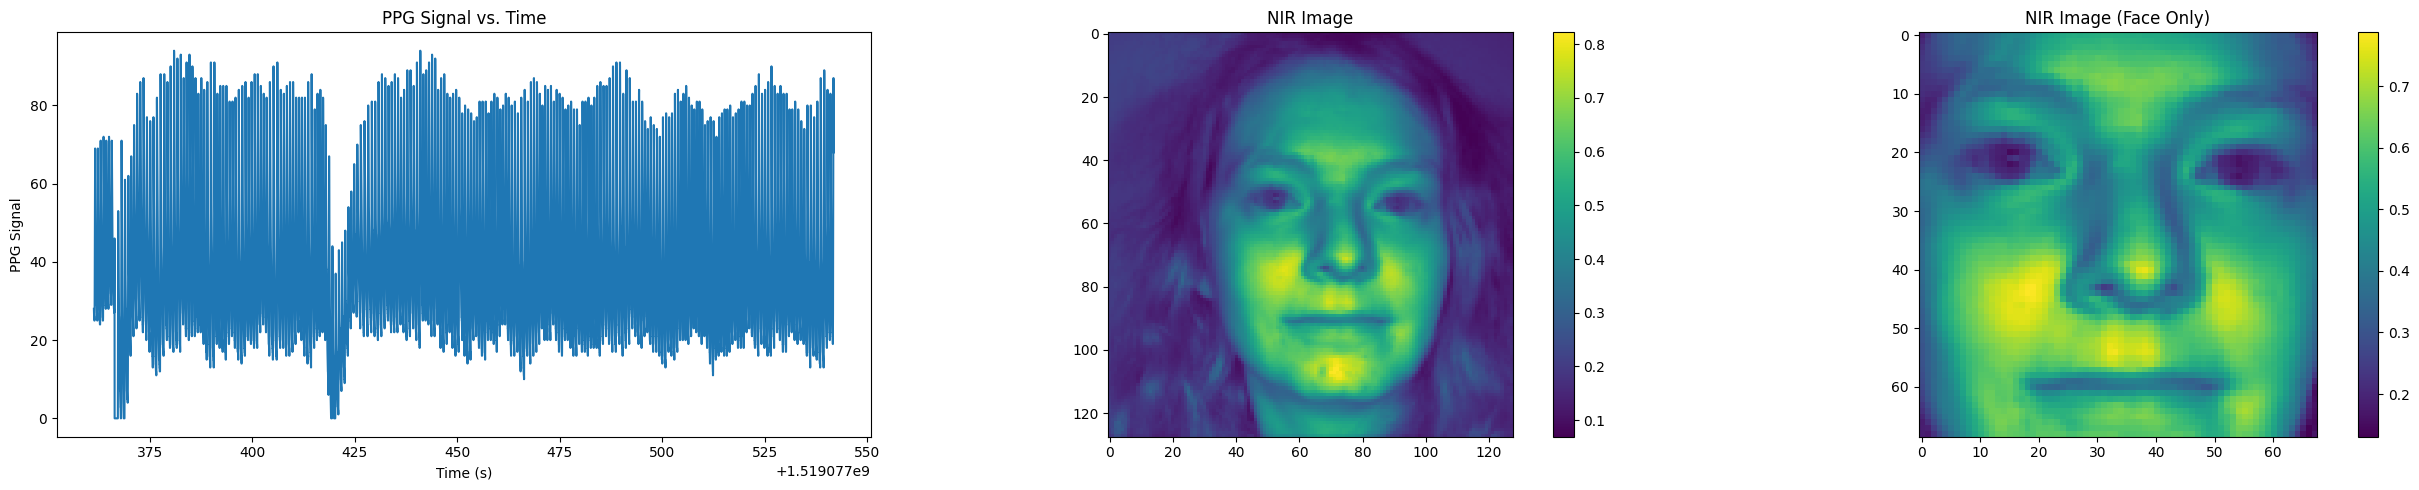

Loading /mnt/Data/MR-NIRP_Indoor/Subject1_still_940.npz
nir_imgs.shape=(5386, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.038773175, nir_imgs.max()=0.6774395
ppg_labels.shape=(10755,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=110
ppg_time.shape=(10755,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519076625.615809, ppg_time.max()=1519076805.217247
face_locations.shape=(5386, 4), face_locations.dtype=dtype('int64'), face_locations.min()=20, face_locations.max()=105


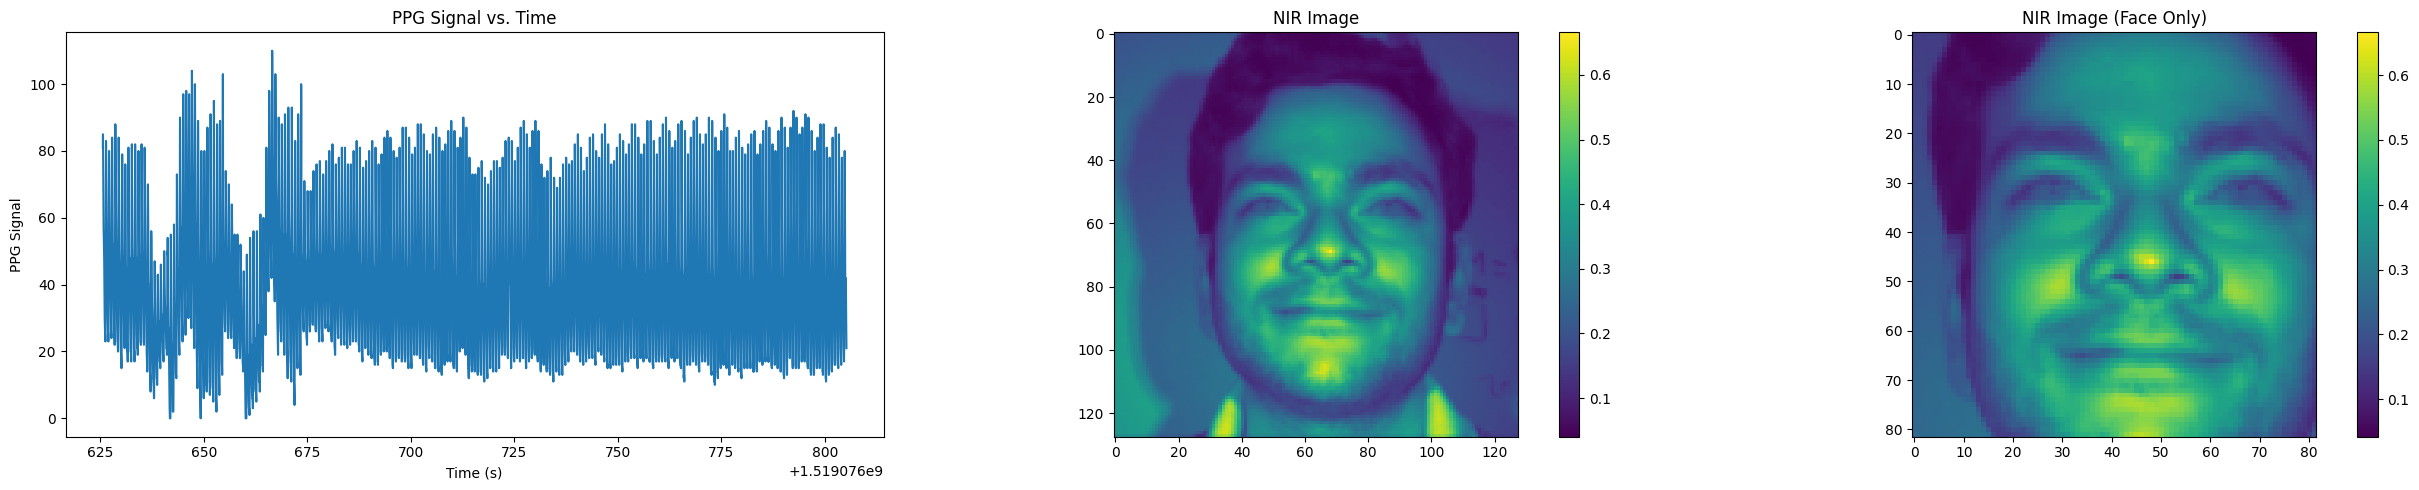

Loading /mnt/Data/MR-NIRP_Indoor/Subject3_still_940.npz
nir_imgs.shape=(7230, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.046707865, nir_imgs.max()=0.75344473
ppg_labels.shape=(14440,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=112
ppg_time.shape=(14440,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519082847.056292, ppg_time.max()=1519083088.199277
face_locations.shape=(7230, 4), face_locations.dtype=dtype('int64'), face_locations.min()=3, face_locations.max()=105


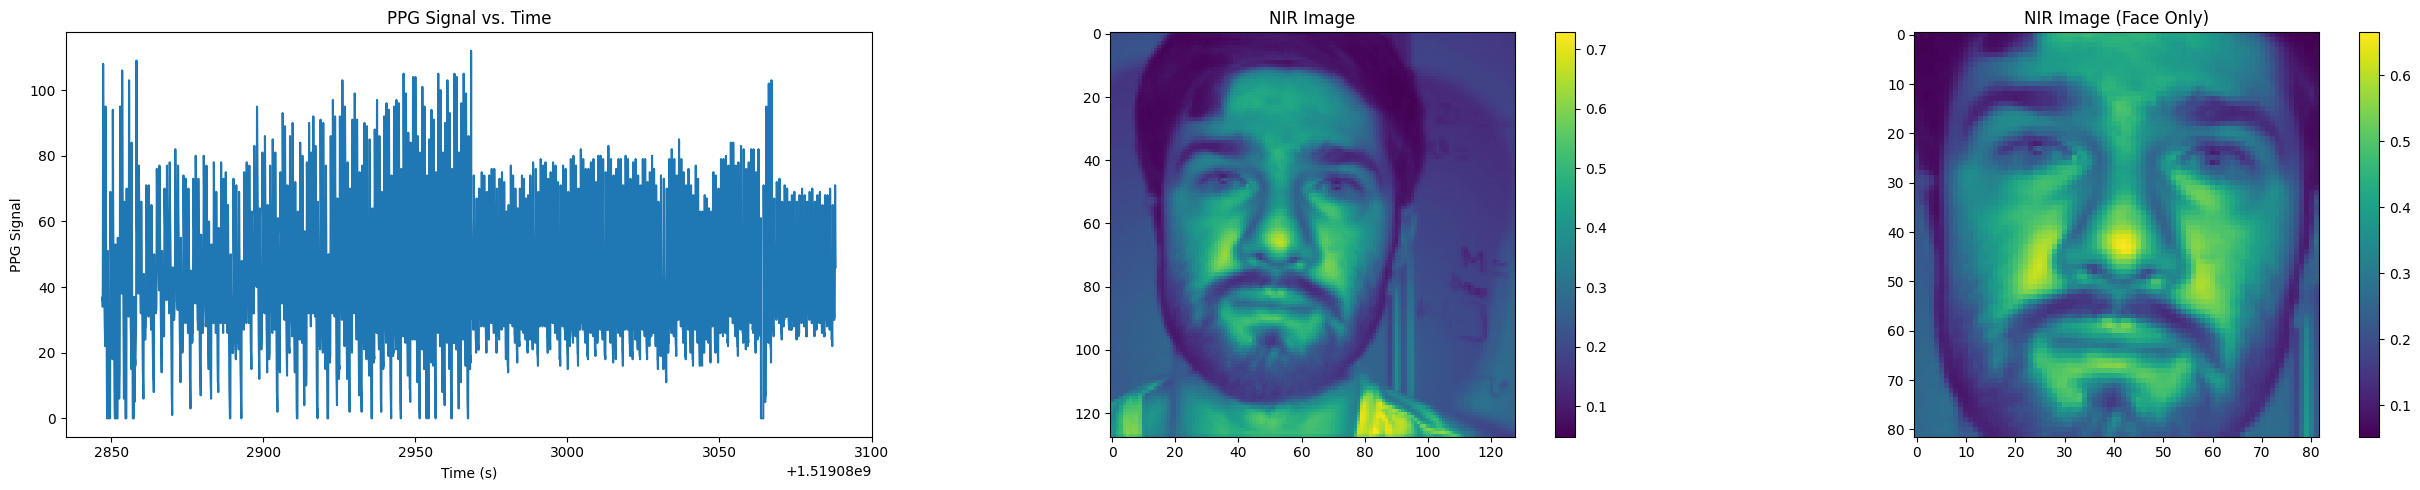

Loading /mnt/Data/MR-NIRP_Indoor/Subject3_motion_940.npz
nir_imgs.shape=(1817, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.044235904, nir_imgs.max()=0.62043184
ppg_labels.shape=(3628,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=112
ppg_time.shape=(3628,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519084006.244459, ppg_time.max()=1519084066.813915
face_locations.shape=(1817, 4), face_locations.dtype=dtype('int64'), face_locations.min()=9, face_locations.max()=113


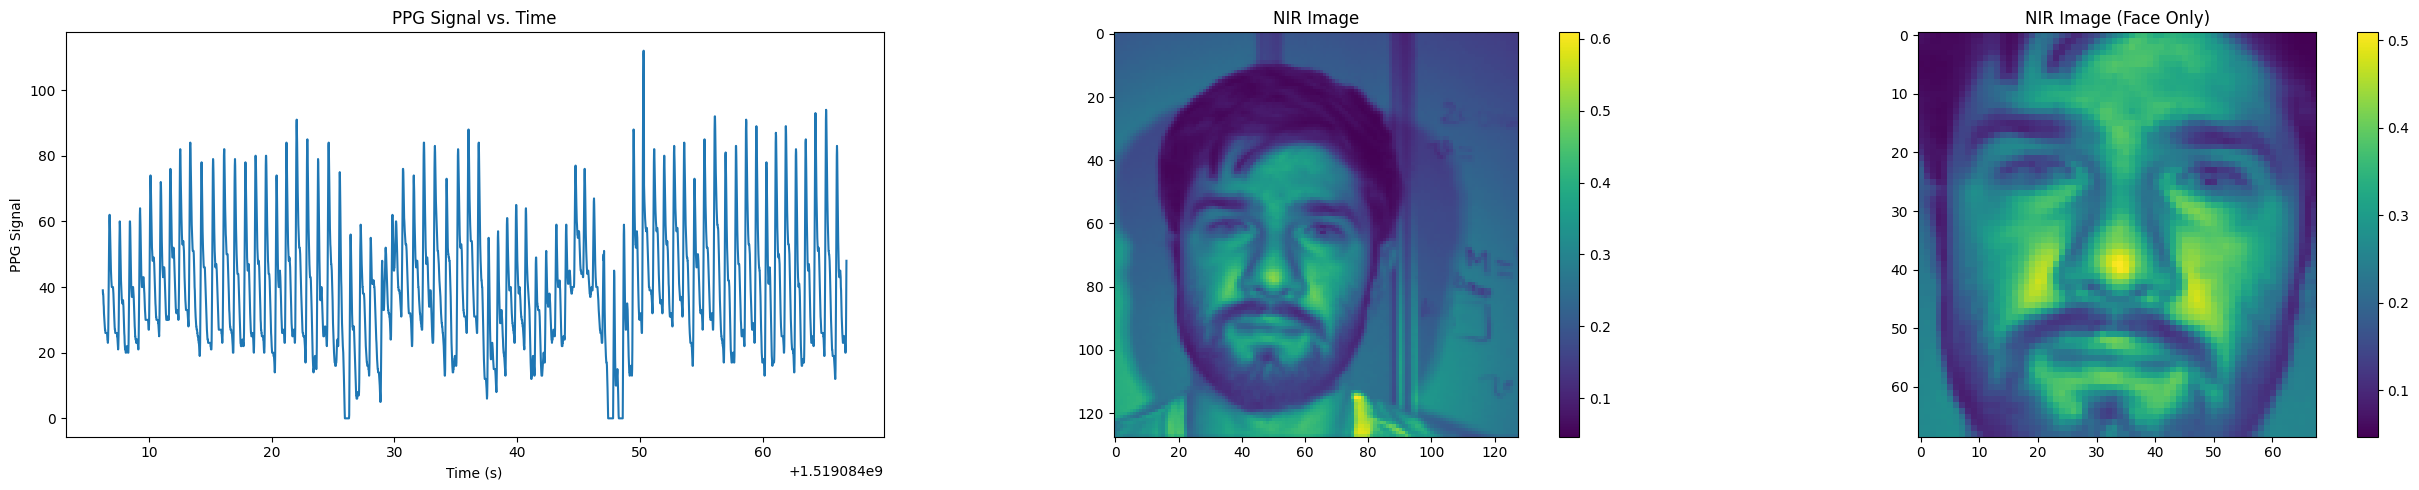

Loading /mnt/Data/MR-NIRP_Indoor/Subject1_motion_940.npz
nir_imgs.shape=(1967, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.03994812, nir_imgs.max()=0.7066453
ppg_labels.shape=(3929,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=104
ppg_time.shape=(3929,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519076918.648566, ppg_time.max()=1519076984.249431
face_locations.shape=(1967, 4), face_locations.dtype=dtype('int64'), face_locations.min()=10, face_locations.max()=120


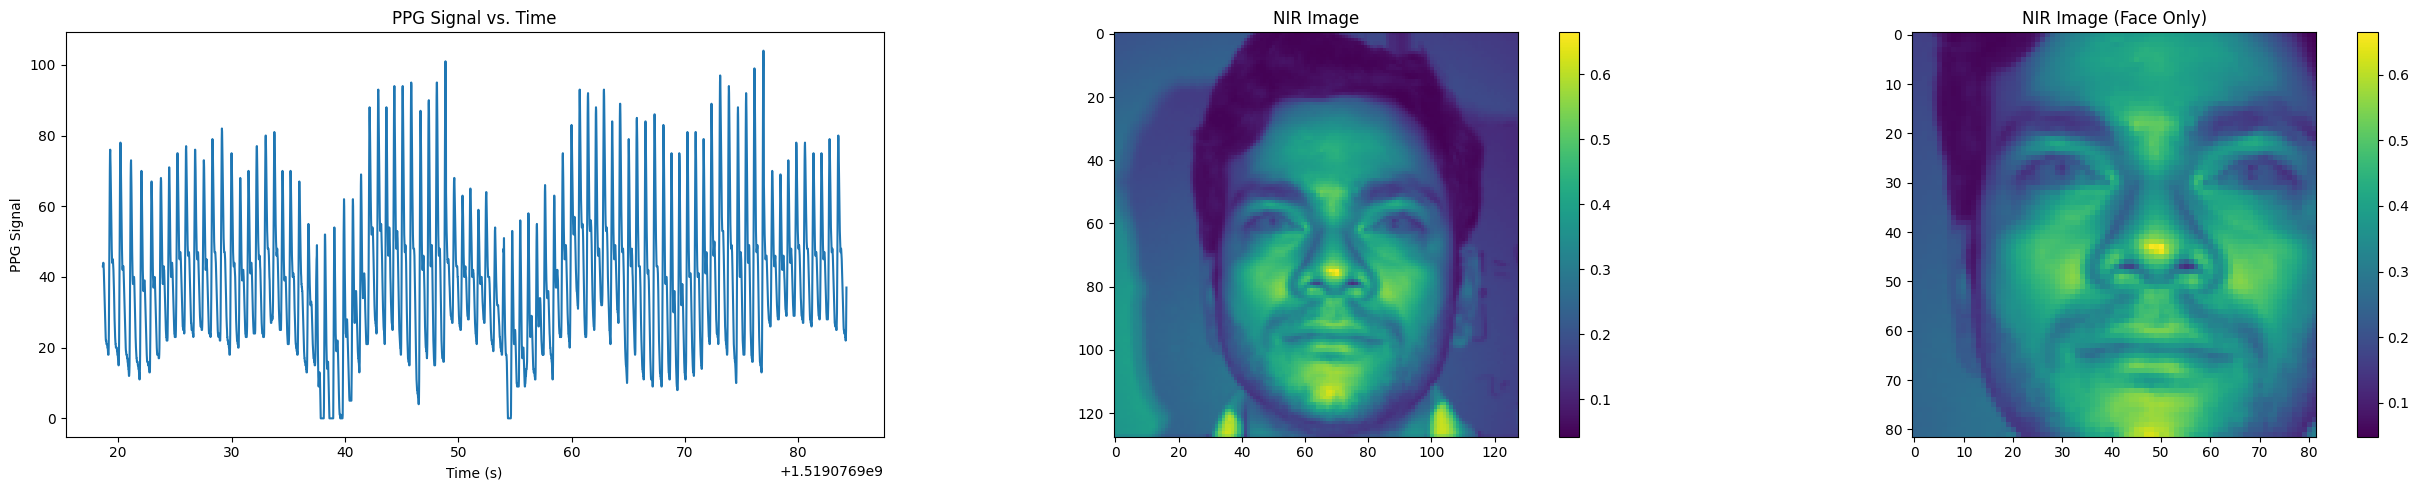

Loading /mnt/Data/MR-NIRP_Indoor/Subject2_motion_940.npz
nir_imgs.shape=(1821, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.049546044, nir_imgs.max()=0.6962844
ppg_labels.shape=(3643,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=96
ppg_time.shape=(3643,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519084528.462929, ppg_time.max()=1519084589.28734
face_locations.shape=(1821, 4), face_locations.dtype=dtype('int64'), face_locations.min()=9, face_locations.max()=107


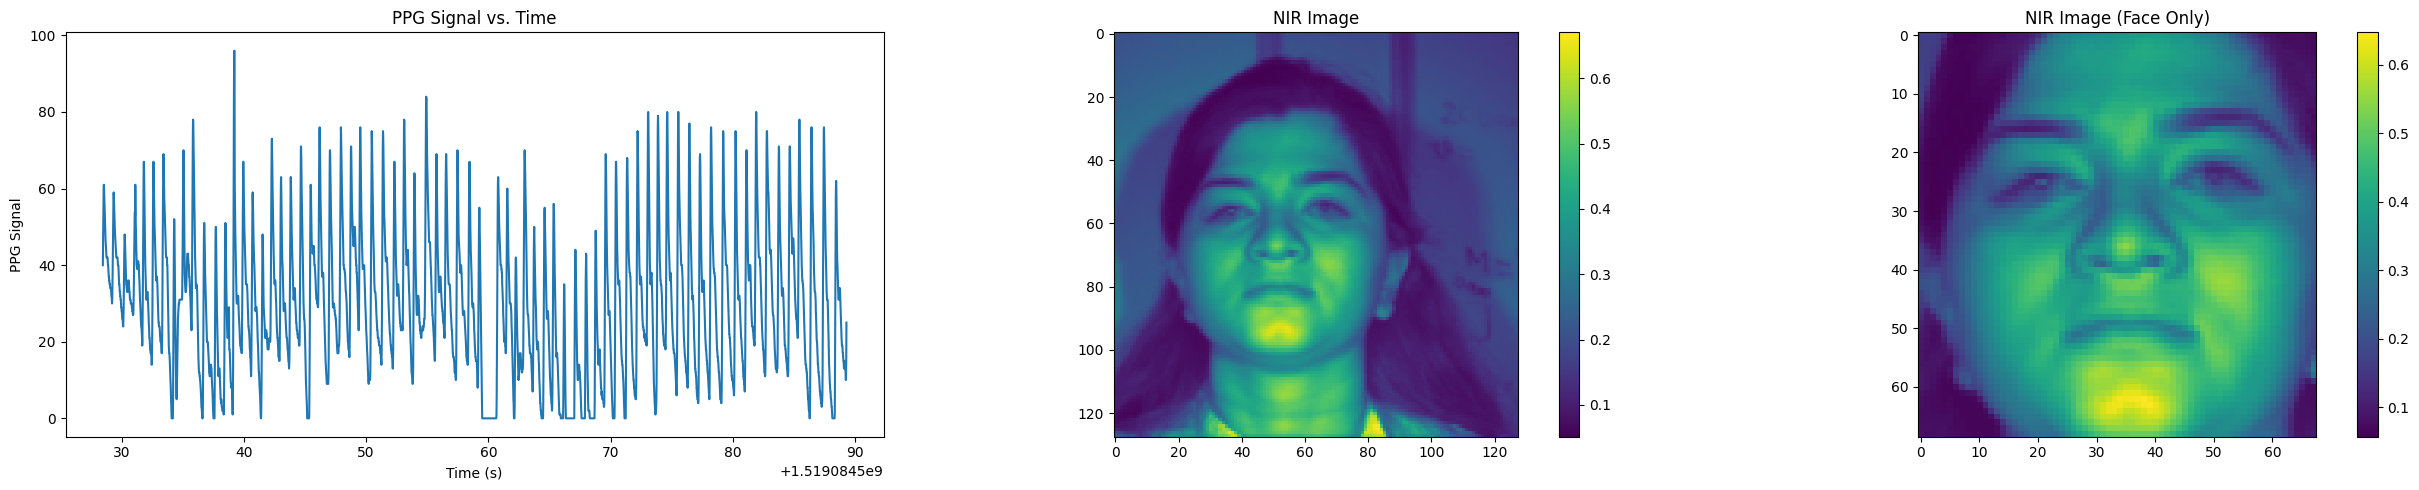

Loading /mnt/Data/MR-NIRP_Indoor/Subject4_motion_940.npz
nir_imgs.shape=(1847, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.047486078, nir_imgs.max()=0.9010758
ppg_labels.shape=(3686,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=0, ppg_labels.max()=101
ppg_time.shape=(3686,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519068696.850391, ppg_time.max()=1519068758.392944
face_locations.shape=(1847, 4), face_locations.dtype=dtype('int64'), face_locations.min()=11, face_locations.max()=120


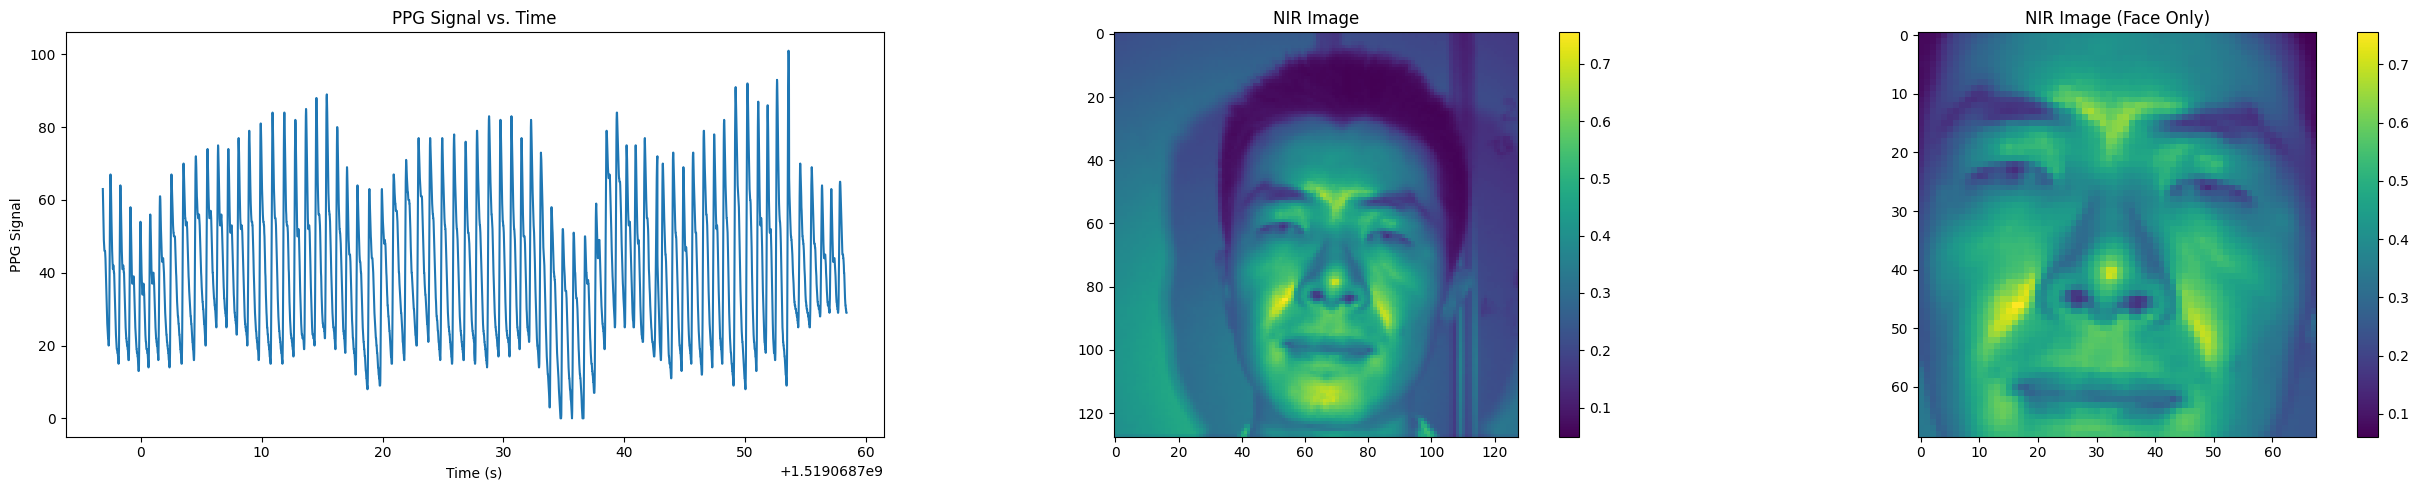

Loading /mnt/Data/MR-NIRP_Indoor/Subject4_still_940.npz
nir_imgs.shape=(5411, 128, 128), nir_imgs.dtype=dtype('float32'), nir_imgs.min()=0.04789807, nir_imgs.max()=0.78959334
ppg_labels.shape=(10806,), ppg_labels.dtype=dtype('int64'), ppg_labels.min()=15, ppg_labels.max()=89
ppg_time.shape=(10806,), ppg_time.dtype=dtype('float64'), ppg_time.min()=1519068307.784869, ppg_time.max()=1519068488.239921
face_locations.shape=(5411, 4), face_locations.dtype=dtype('int64'), face_locations.min()=23, face_locations.max()=114


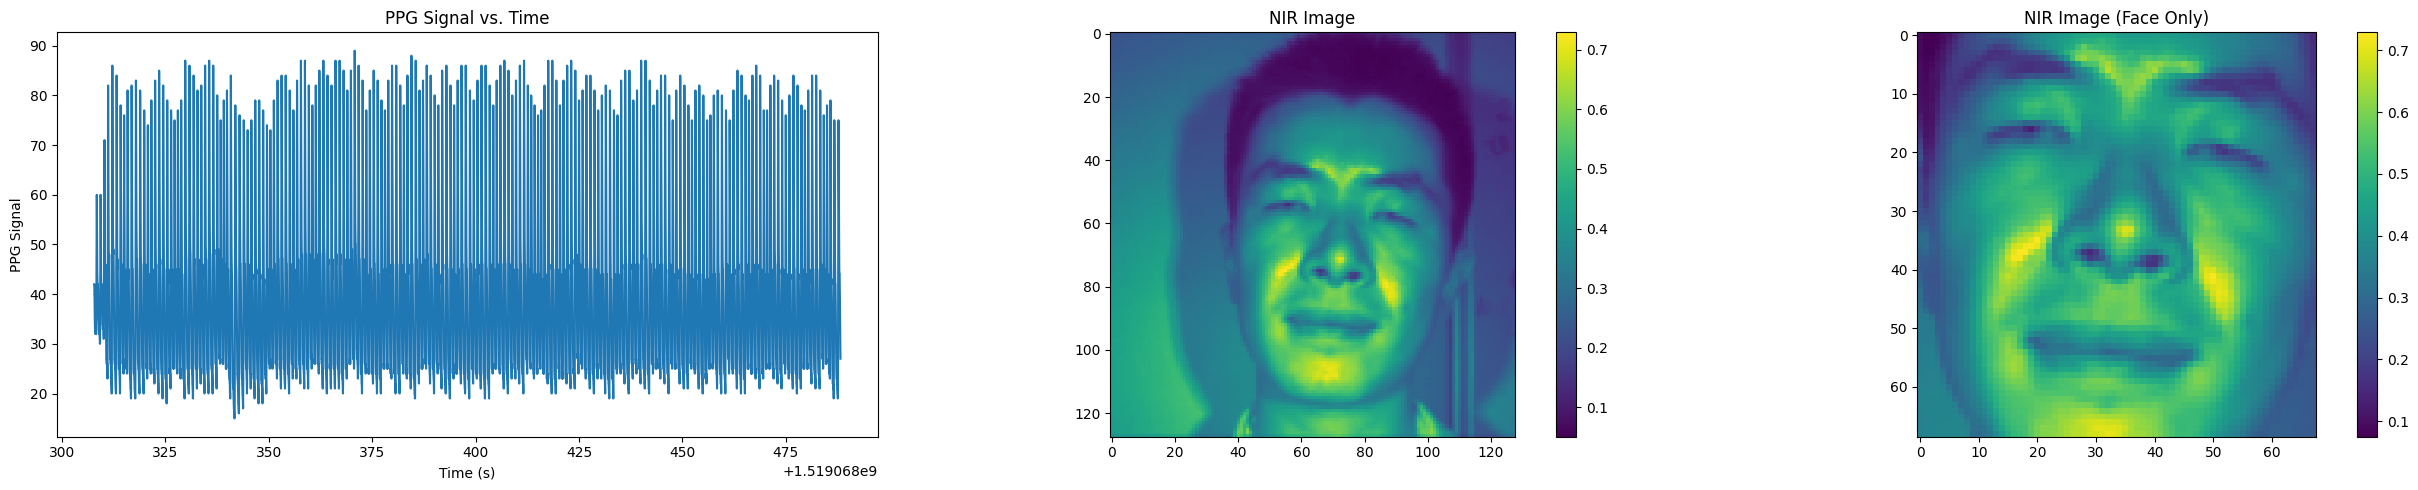

In [4]:
# Load each npz file and plot the first frame and the ppg signal
for subject_npz_path in glob.glob(os.path.join(dataset_root_path, "*.npz")):
    print(f"Loading {subject_npz_path}")
    subject_npz = np.load(subject_npz_path)
    nir_imgs = subject_npz["nir_imgs"]
    ppg_labels = subject_npz["ppg_labels"]
    ppg_time = subject_npz["ppg_time"]
    face_locations = subject_npz["face_locations"]

    print(f"{nir_imgs.shape=}, {nir_imgs.dtype=}, {nir_imgs.min()=}, {nir_imgs.max()=}")
    print(f"{ppg_labels.shape=}, {ppg_labels.dtype=}, {ppg_labels.min()=}, {ppg_labels.max()=}")
    print(f"{ppg_time.shape=}, {ppg_time.dtype=}, {ppg_time.min()=}, {ppg_time.max()=}")
    print(f"{face_locations.shape=}, {face_locations.dtype=}, {face_locations.min()=}, {face_locations.max()=}")

    # Plot the ppg signal and nir image in the first frame together
    plt.figure(figsize=(25, 5))
    plt.subplot(1, 3, 1)
    plt.plot(ppg_time, ppg_labels)
    plt.xlabel("Time (s)")
    plt.ylabel("PPG Signal")
    plt.title("PPG Signal vs. Time")
    plt.subplot(1, 3, 2)
    plt.imshow(nir_imgs[0])
    plt.title("NIR Image")
    plt.colorbar()
    plt.subplot(1, 3, 3)
    left, top, right, bottom = face_locations[0]
    plt.imshow(nir_imgs[0][max(0, top):min(nir_imgs[0].shape[1], bottom), max(0, left):min(nir_imgs[0].shape[0], right)])
    plt.title("NIR Image (Face Only)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()